In [281]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.manual_seed(42)
height, width, channel = 4, 4, 3
num_kernels = 4

input = torch.stack([
    torch.linspace(0, 1, height*width),
    torch.linspace(1, 0, height*width),
    torch.linspace(0, 0, height*width),
]).view(channel, height, width)

kernels = torch.stack([
    torch.linspace(0, 1, num_kernels),
    torch.linspace(1, 0, num_kernels),
    torch.linspace(0, 0, num_kernels),
], dim=1).view(num_kernels, channel, 1, 1)

# 4a i. 

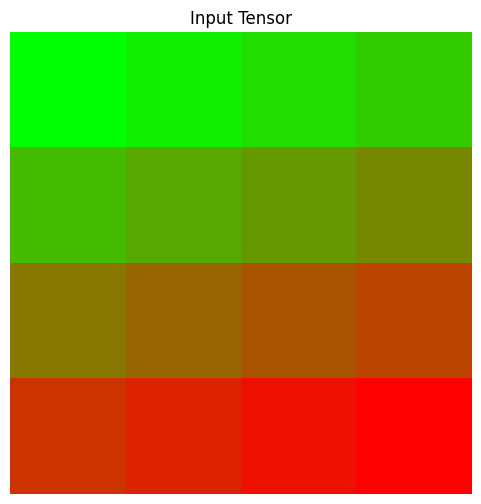

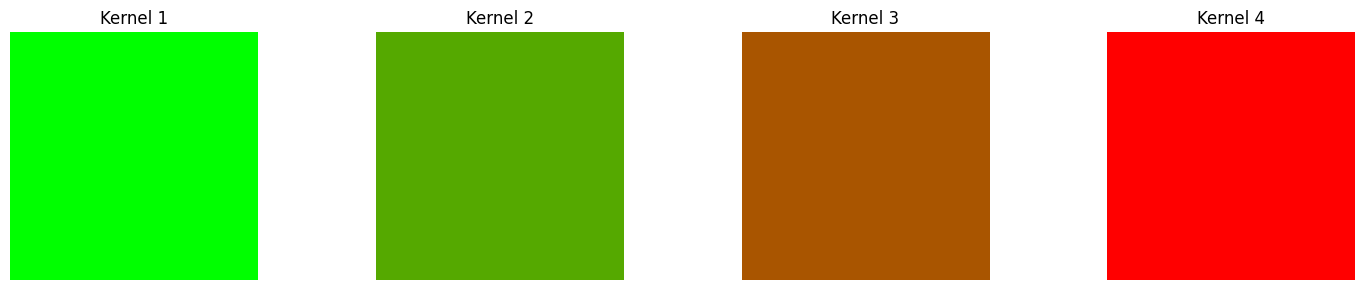

In [282]:

# Visualize input tensor
plt.figure(figsize=(6, 6))
plt.imshow(input.permute(1, 2, 0))
plt.title('Input Tensor')
plt.axis('off')
plt.show()

# Visualize kernels
fig, axes = plt.subplots(1, num_kernels, figsize=(15, 3))
for i in range(num_kernels):
    axes[i].imshow(kernels[i].permute(1, 2, 0))
    axes[i].set_title(f'Kernel {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()


# 4a ii. 

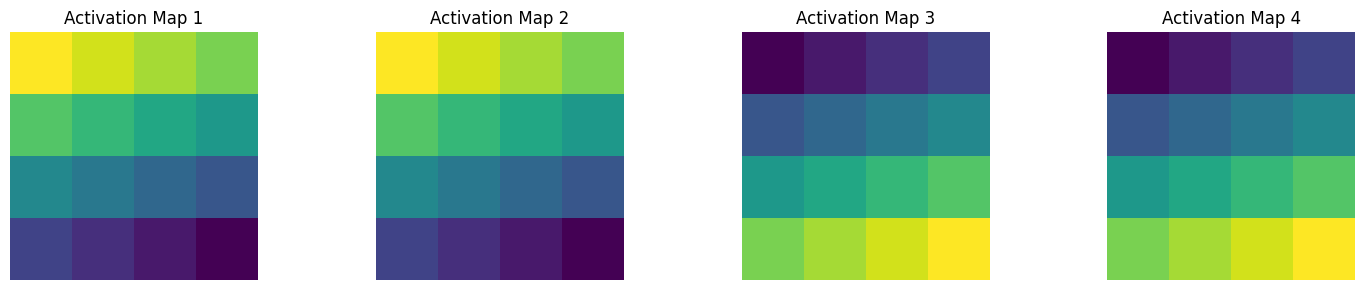

In [283]:
# Perform convolution
output = F.conv2d(input.unsqueeze(0), kernels)
# Visualize activation maps
output 

fig, axes = plt.subplots(1, num_kernels, figsize=(15, 3))
for i in range(num_kernels):
    axes[i].imshow(output[0, i].detach(), cmap='viridis')
    axes[i].set_title(f'Activation Map {i+1}')
    axes[i].axis('off')
plt.tight_layout()
plt.show()

A different view to see the numbers.


I will go through the four rules: 
1. s is bounded above by some value b. This rule holds.
2. The similarity between an object and itself is the maximum similarity possible. This does not hold as you can see in kernel map 2 and 3 (they have the corners larger then the color that match's closer in the middle)
3. The similarity between two distinct objects is not the maximum similarity. This does not hold as we see in kernel maps two and three (where two distinct objects have the max)
4. Similarity is symmetric. This holds (2 and 3 and 1 and 4 are symmetric)


# 4a iii.

$$
\text{CosSim}(x, y) := \cos(\theta(x, y))
$$

$\textbf{Properties:}$

1. $\textbf{Boundedness:}$ As $\cos(\theta) \in [-1, 1]$ we know $\text{CosSim}(x, y) \leq b = 1$  

2. $\textbf{Self-Similarity:}$ $\text{CosSim}(x, x) = \cos(0) = 1 = b$

3. $\textbf{Distinctness:}\text{CosSim}(x, y) = \cos(\theta(x, y)) < 1$. is always true assuming $x \neq ky, k>0$. I had to slightly change the definition to show that the direction must be different not just the magnitude.

4. $\textbf{Symmetry:}$ $\text{CosSim}(x, y) = \cos(\theta(x, y)) = \cos(\theta(y, x)) = \text{CosSim}(y, x)$. AKA it doesn't matter which direction you take the angle from. 

$\textbf{Conclusion:}$ Cosine similarity satisfies all four properties, thus it is a valid similarity metric.

# 4a iv.

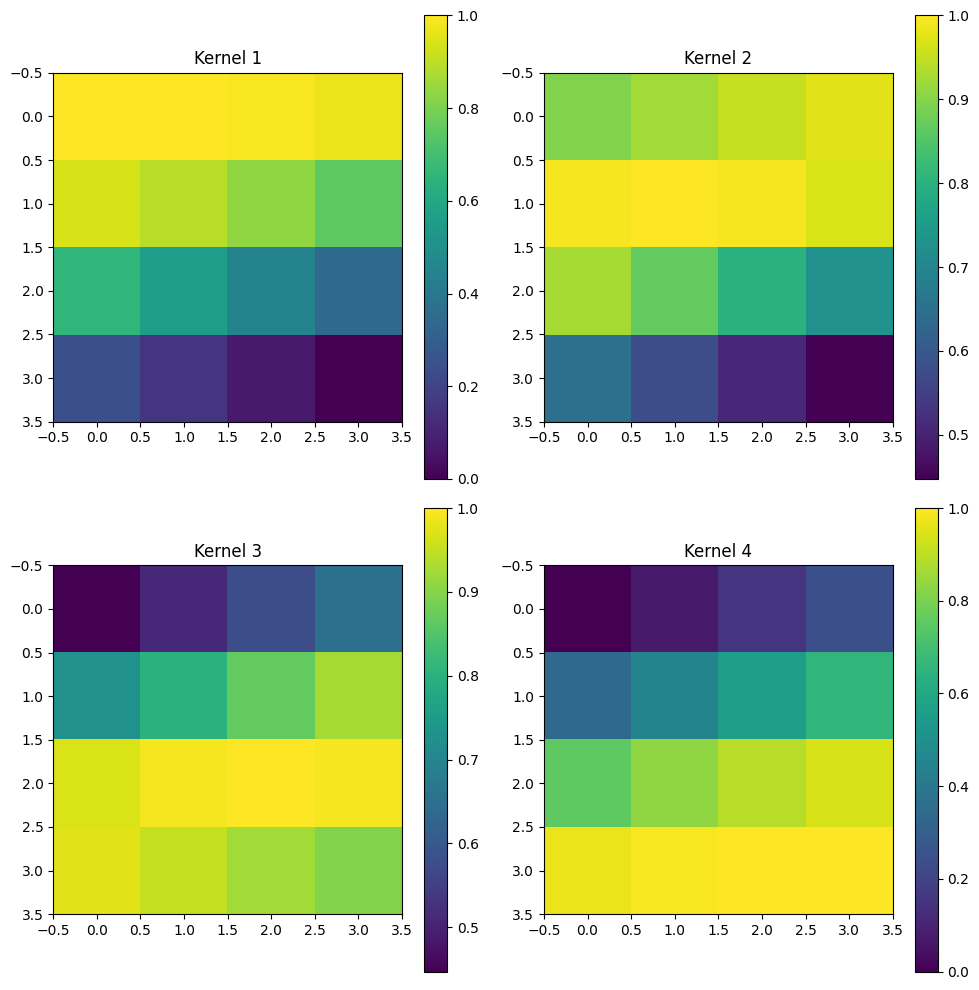

In [284]:
x = input
y = kernels
input_norm = torch.norm(input.unsqueeze(0), p=2, dim=1, keepdim=True)
kernel_norm = torch.norm(kernels, p=2, dim=1, keepdim=True)
x_norm = x/input_norm
y_norm = y/kernel_norm

cos_sim = F.conv2d(x_norm, y_norm)

# Display activation maps
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(cos_sim[0, i].detach().numpy(), cmap='viridis')
    ax.set_title(f'Kernel {i+1}')
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()



The activation maps do now reflect a similarity function.

This implementation differs from a normal convolution in that:
* Both input and kernels are normalized before convolution.
* The output represents cosine similarity now
* It's invariant to the scale of the input and kernels (aka they have been normalized).


# 4b i. 

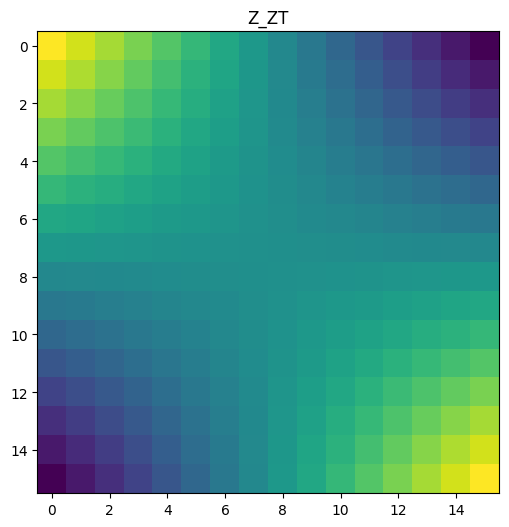

In [285]:

Z_T = input.view(channel, -1)
Z = torch.transpose(Z_T,0 , 1)
Z_ZT = (Z @ Z_T)
# Visualize 
plt.figure(figsize=(6, 6))
plt.imshow(Z_ZT)
plt.title('Z_ZT')
plt.show()

The rules for similarity functions is violated. For a similarity function with (Z*Z_T) the diagonal should the $s(x, x) = b$, and thus the most yellow. However, it is clearly not so this is not a similarity function.

# 4 bii.

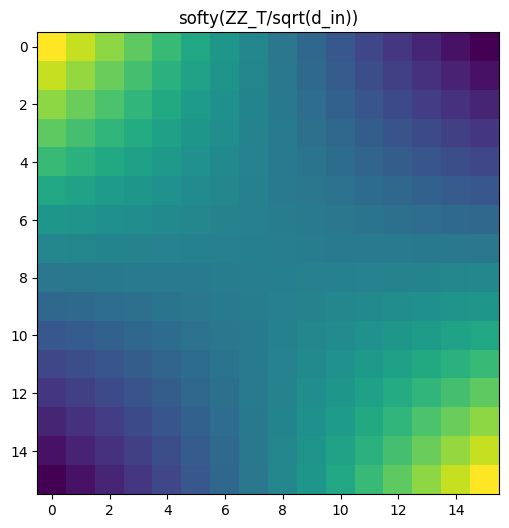

In [286]:
import numpy as np
Z_a = Z_ZT/np.sqrt(3)
flat = torch.flatten(Z_a)

softy = torch.softmax((flat), dim = 0)
softy = softy.reshape(16, 16)

softy
plt.figure(figsize=(6, 6))
plt.imshow(softy)
plt.title('softy(ZZ_T/sqrt(d_in))')
plt.show()

The rules for similarity functions is violated. For a similarity function with (Z*Z_T) the diagonal should the $s(x, x) = b$, and thus the most yellow. However, it is clearly not so this is not a similarity function.

# 4 biii.

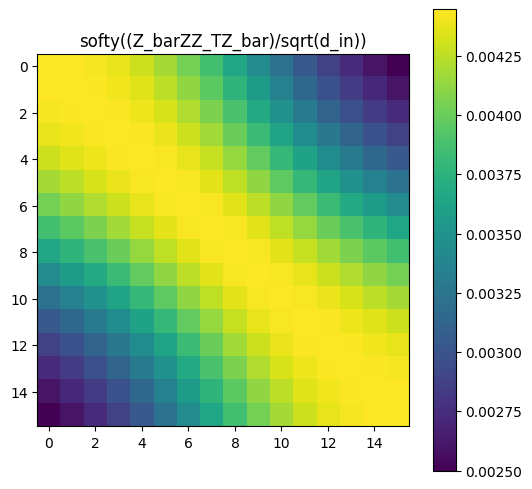

In [305]:

l2_norms = torch.norm(Z, p=2, dim=1, keepdim=True)
l2_norms2 = 1 / l2_norms
Z_bar = torch.diag(1/l2_norms.view(-1))

indiside_math = Z_bar@Z_ZT@Z_bar/np.sqrt(3)

flat = torch.flatten(indiside_math)

softy = torch.softmax((flat), dim = 0)
softy = softy.reshape(16, 16)

plt.figure(figsize=(6, 6))
plt.imshow(softy)
plt.title('softy((Z_barZZ_TZ_bar)/sqrt(d_in))')
plt.colorbar()

plt.show()


In [289]:
torch.set_printoptions(precision=10)
print(softy[0])

tensor([0.0044458844, 0.0044393661, 0.0044161365, 0.0043699020, 0.0042939992,
        0.0041829902, 0.0040350272, 0.0038540666, 0.0036503258, 0.0034379829,
        0.0032311154, 0.0030402325, 0.0028709888, 0.0027248650, 0.0026006540,
        0.0024958479])


The entries in this matrix could be produced by a similarity function. AKA: The rules for similarity functions are not violated. You can tell because it is symmetric along the diagonal (s(x, y) = s(y, x)) and the diagonal has the highest values (AKA s(x=x)=B). Also since it is the largest on the diagonal, and only on the diagonal, you can tell that s(x, y) < b. Note I printed the first row just to make sure that the off-diag values are different then the diag values

# 4 biv.

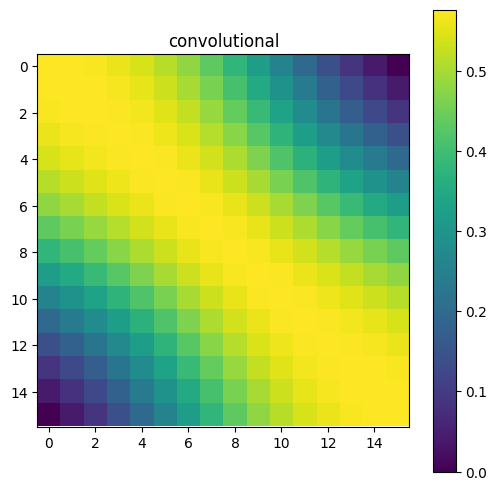

In [330]:
left = Z_bar @ Z
right = Z_T@Z_bar

# Reshape the tensor
kernels_2 = left.reshape(16, 3, 1, 1)
input2 = right.reshape(3, 4, 4)

output = F.conv2d(input2,kernels_2)
output  = output/np.sqrt(3)

output = output.view(16,-1)
plt.figure(figsize=(6, 6))
plt.imshow(output)
plt.title('convolutional')
plt.colorbar()
plt.show()


My kernels shape is (16, 3, 1, 1). So we had 16 kernels (one for each pixel) 
